In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, HashingTF
from pyspark.sql.functions import udf, col, lower, regexp_replace, split, explode, length, monotonically_increasing_id, collect_list
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, StructType, StructField
from pyspark.ml import Pipeline
import dill
import math
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keybert import KeyBERT
import yake
import seaborn as sns
import pandas as pd
import networkx as nx
import spacy
import pytextrank
from rake_nltk import Rake
from itertools import cycle

In [2]:
# creating the session
spark = SparkSession.builder \
    .config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1/data_engineering.preprocessed.coll") \
    .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1/data_engineering.preprocessed.coll") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.1.1") \
    .config("spark.rdd.compress", "true") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/05/01 16:52:47 WARN Utils: Your hostname, LAPTOP-KHLEE resolves to a loopback address: 127.0.1.1; using 172.24.76.154 instead (on interface eth0)
23/05/01 16:52:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/hduser/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hduser/.ivy2/cache
The jars for the packages stored in: /home/hduser/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c25c20bf-7af7-4ce4-be95-f3cdadc698cd;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.1.1 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 4537ms :: artifacts dl 52ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-core;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-sync;4.8.2 from central in [default]
	org.mongodb.spark#mongo-spark-connector

In [3]:
spark_df = spark.read.format("mongodb").load().cache()

In [4]:
spark_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- url: string (nullable = true)



In [5]:
# show table
spark_df.select("tokens").show(n=5, truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                       |
+-------------------------------------------------------------------------------------------------------------+
|[art, cram, school, malaysia]                                                                                |
|[place, read, comic]                                                                                         |
|[hear, katakata, pm, believe, nelayan, pulau, pinang]                                                        |
|[interested, industrial, design]                                                                             |
|[judge, pm, solely, state, poll, result, state, unique, issue, linked, unity, government, performance, fahmi]|
+-------------------------------------------------------------------------------------------------------

In [6]:
# get the number of rows
spark_df.select("tokens").count()

134

### Top 20 keywords in the dataset

In [7]:
def generate_top_keywords(df, column_name, top_n):
    # Explode the tokens in the column into separate rows
    exploded_df = df.select(explode(col(column_name)).alias('token'))

    # Filter out any empty or null tokens
    filtered_df = exploded_df.filter((col('token') != '') & col('token').isNotNull())

    # Group by token and count the occurrences of each token
    token_counts = filtered_df.groupBy('token').count()
    
    # Sort by count in descending order and select the top n tokens
    top_token_counts = token_counts.orderBy('count', ascending=False).limit(top_n)
    
    # Collect the results into a list and return it
    top_tokens = [row['token'] for row in top_token_counts.collect()]
    return top_tokens

# get top 20 keywords
top_keywords = generate_top_keywords(spark_df, 'tokens', 20)
print(top_keywords)

['malaysia', 'say', 'malaysian', 'najib', 'government', 'pardon', 'pm', 'umno', 'kedah', 'house', 'state', 'trust', 'open', 'anwar', 'school', 'may', 'unity', 'madani', 'question', 'pas']


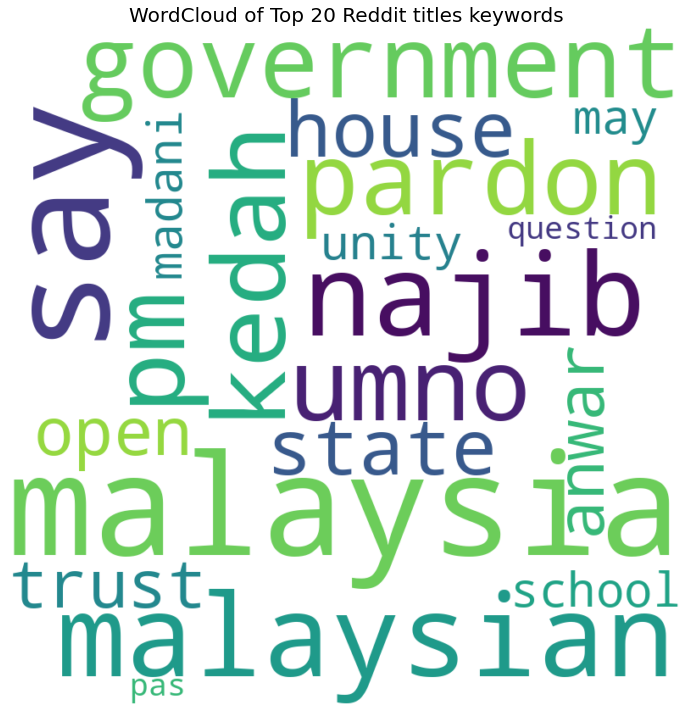

In [8]:
# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(" ".join(top_keywords))

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("WordCloud of Top 20 Reddit titles keywords", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

### WordCloud - by frequency

In [9]:
# Flatten the DataFrame to get a single column of words
words_df = spark_df.select(explode(col("tokens")).alias('word'))

# Create an RDD from the flattened DataFrame
words_rdd = words_df.rdd

# Assign a count of 1 to each word in the list
words_rdd = words_rdd.map(lambda word: (word, 1))

# Aggregate the counts of each word
word_counts_rdd = words_rdd.reduceByKey(lambda x, y: x + y)

# Sort the results by count in descending order
sorted_word_counts_rdd = word_counts_rdd.sortBy(lambda x: x[1], ascending=False)

# Convert the resulting RDD to a list
sorted_word_counts_list = sorted_word_counts_rdd.collect()

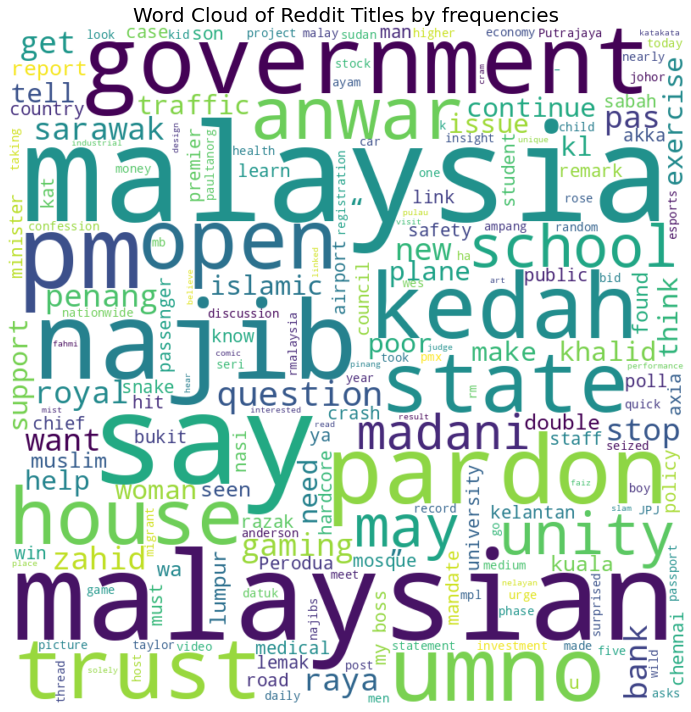

In [10]:
# Convert the sorted word counts list to a dictionary
word_counts_dict = dict(sorted_word_counts_list)

# Convert the word counts to a dictionary with string keys
word_counts_dict = {str(k["word"]): v for k, v in word_counts_dict.items()}

# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white',).generate_from_frequencies(word_counts_dict)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("Word Cloud of Reddit Titles by frequencies", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

### Mask in the shape of Malaysia flag

(-0.5, 799.5, 399.5, -0.5)

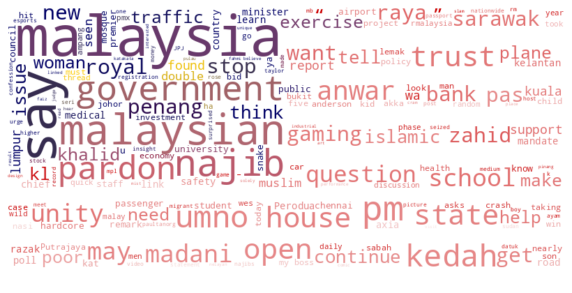

In [11]:
# Generate a word cloud image
mask = np.array(Image.open("./malaysia.png"))
wordcloud_malaysia = WordCloud(background_color="white", mode="RGBA", mask=mask).generate_from_frequencies(word_counts_dict)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_malaysia.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

#### Visualize the top 20 frequency of keywords in bar chart

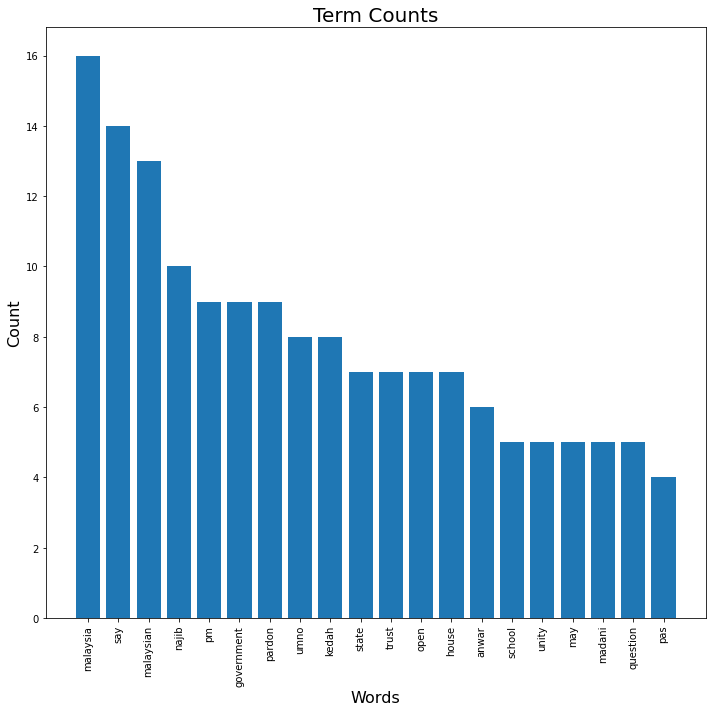

In [12]:
#  Convert the sorted word counts list to a dictionary
word_counts_dict = dict(sorted_word_counts_list)

# Convert the word counts to a dictionary with string keys
word_counts_dict = {str(k["word"]): v for k, v in word_counts_dict.items()}

# Get the words and their counts as separate lists
words = list(word_counts_dict.keys())[:20]
counts = list(word_counts_dict.values())[:20]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(words, counts)

# Customize the appearance
ax.set_title("Term Counts", fontsize=20)
ax.set_xlabel("Words", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

### Unigrams of the dataset

In the code above, we first select the "tokens" column from the input DataFrame "spark_df". Then, we convert this column to an RDD using the "rdd" attribute and apply the "flatMap" transformation to each row of the RDD. The lambda function inside the flatMap function returns a list with each token as a separate element. We then use the "map" transformation to convert each token into a tuple with a single element, and create a DataFrame from this RDD with the column name "word" using the "toDF" function. Finally, we show the resulting DataFrame using the "show" method. This code generates a DataFrame with each row representing a single token from the input DataFrame.

In [13]:
unigrams_df = spark_df.select("tokens").rdd.flatMap(lambda row: row[0]).map(lambda word: (word,)).toDF(["word"])

# Show the results
unigrams_df.show(truncate=False)

+----------+
|word      |
+----------+
|art       |
|cram      |
|school    |
|malaysia  |
|place     |
|read      |
|comic     |
|hear      |
|katakata  |
|pm        |
|believe   |
|nelayan   |
|pulau     |
|pinang    |
|interested|
|industrial|
|design    |
|judge     |
|pm        |
|solely    |
+----------+
only showing top 20 rows



#### Bar chart of top 20 unigrams

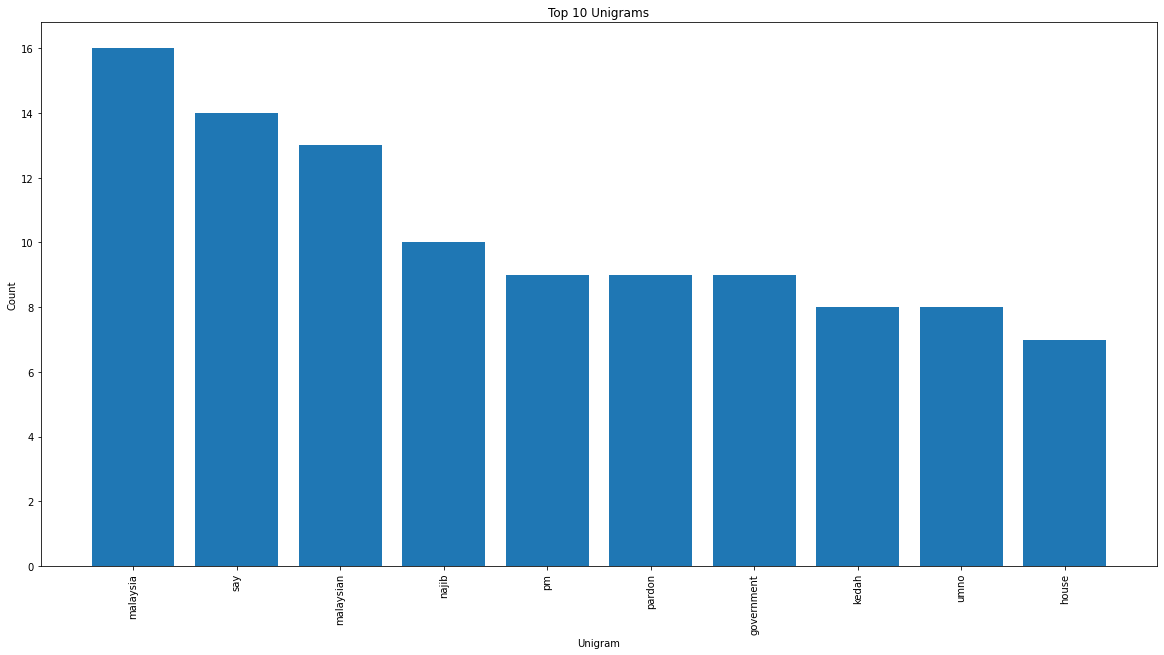

In [14]:
# Group the unigrams DataFrame by the "word" column, and count the occurrences of each unigram
unigram_counts = unigrams_df.groupBy("word").count()

# Sort the unigram counts in descending order
unigram_counts = unigram_counts.orderBy("count", ascending=False)

# Take the top 10 unigram counts
top_unigram_counts = unigram_counts.limit(10)

# Convert the top unigram counts to a Pandas DataFrame
top_unigram_counts_df = top_unigram_counts.toPandas()

# Plot the top 10 unigram counts as a bar chart
plt.figure(figsize=(20,10))
plt.bar(x=top_unigram_counts_df["word"], height=top_unigram_counts_df["count"])
plt.xticks(rotation=90)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Top 10 Unigrams")
plt.show()

#### WordCloud for top 20 unigrams

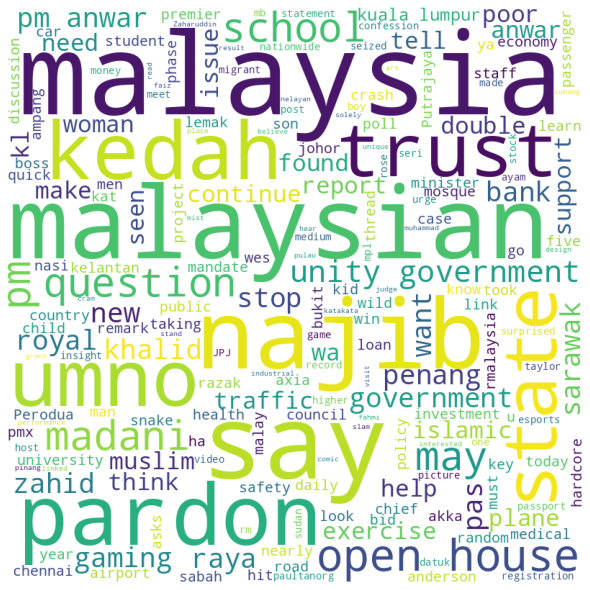

In [15]:
# Convert the DataFrame to a list of words
words = unigrams_df.rdd.map(lambda row: row[0]).collect()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(words))

# Visualize the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Bigrams of the dataset

We then convert the DataFrame to an RDD using the rdd attribute, and apply the flatMap transformation to each row of the RDD. The flatMap function takes a lambda function that returns a list of bigrams for each row of the DataFrame. We use a list comprehension to generate the bigrams for each row, using a sliding window of size 2.

Finally, we convert the resulting RDD of bigrams to a DataFrame using the toDF function, and specify the column names as "word1" and "word2". We then show the resulting DataFrame.

Note that this approach does not require a UDF, and is often more efficient than using a UDF for simple operations like generating bigrams.

In [16]:
# Generate bigrams using flatMap
bigrams_df = spark_df.select("tokens").rdd.flatMap(lambda row: [(row[0][i], row[0][i+1]) for i in range(len(row[0])-1)]) \
                 .toDF(["word1", "word2"])

# Show the results
bigrams_df.show(truncate=False)

+----------+----------+
|word1     |word2     |
+----------+----------+
|art       |cram      |
|cram      |school    |
|school    |malaysia  |
|place     |read      |
|read      |comic     |
|hear      |katakata  |
|katakata  |pm        |
|pm        |believe   |
|believe   |nelayan   |
|nelayan   |pulau     |
|pulau     |pinang    |
|interested|industrial|
|industrial|design    |
|judge     |pm        |
|pm        |solely    |
|solely    |state     |
|state     |poll      |
|poll      |result    |
|result    |state     |
|state     |unique    |
+----------+----------+
only showing top 20 rows



#### Bar chart of top 20 bigrams

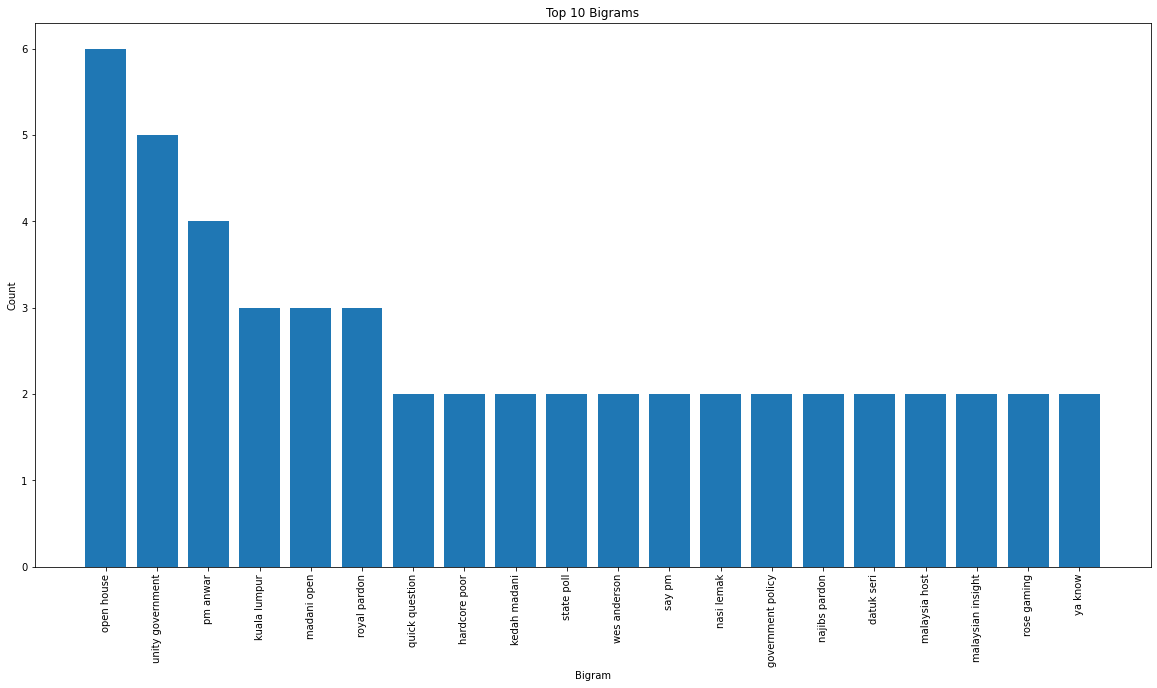

In [17]:
# visualize the top 20 bigrams with bar chart
# Group the bigrams DataFrame by the "word1" and "word2" columns, and count the occurrences of each bigram
bigram_counts = bigrams_df.groupBy("word1", "word2").count()

# Sort the bigram counts in descending order
bigram_counts = bigram_counts.orderBy("count", ascending=False)

# Take the top 20 bigram counts
top_bigram_counts = bigram_counts.limit(20)

# Convert the top bigram counts to a Pandas DataFrame
top_bigram_counts_df = top_bigram_counts.toPandas()

plt.figure(figsize=(20,10))
# Plot the top 10 bigram counts as a bar chart
plt.bar(x=top_bigram_counts_df["word1"] + " " + top_bigram_counts_df["word2"], height=top_bigram_counts_df["count"])
plt.xticks(rotation=90)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 10 Bigrams")
plt.show()

#### WordCloud for top 20 bigrams

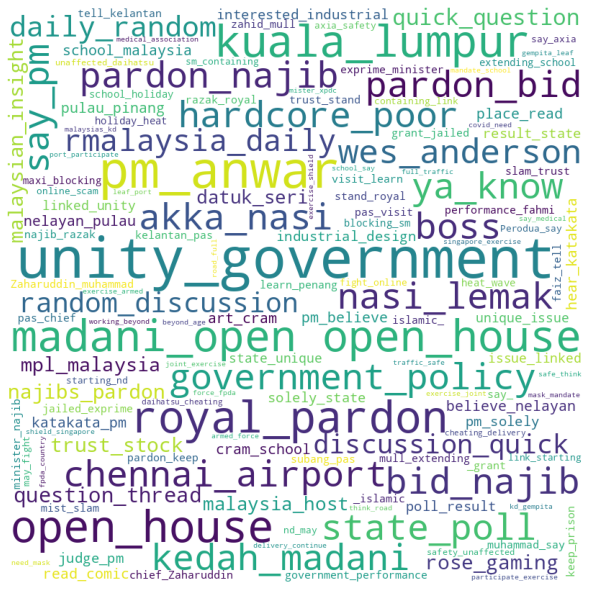

In [18]:
# Convert the DataFrame to a list of bigrams
bigrams = bigrams_df.rdd.map(lambda row: '_'.join(row)).collect()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(bigrams))

# Visualize the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Trigrams of the dataset

In [19]:
# Generate trigrams using flatMap
trigrams_df = spark_df.select("tokens").rdd.flatMap(lambda row: [(row[0][i], row[0][i+1], row[0][i+2]) for i in range(len(row[0])-2)]) \
                 .toDF(["word1", "word2", "word3"])

# Show the results
trigrams_df.show(truncate=False)

+----------+----------+-----------+
|word1     |word2     |word3      |
+----------+----------+-----------+
|art       |cram      |school     |
|cram      |school    |malaysia   |
|place     |read      |comic      |
|hear      |katakata  |pm         |
|katakata  |pm        |believe    |
|pm        |believe   |nelayan    |
|believe   |nelayan   |pulau      |
|nelayan   |pulau     |pinang     |
|interested|industrial|design     |
|judge     |pm        |solely     |
|pm        |solely    |state      |
|solely    |state     |poll       |
|state     |poll      |result     |
|poll      |result    |state      |
|result    |state     |unique     |
|state     |unique    |issue      |
|unique    |issue     |linked     |
|issue     |linked    |unity      |
|linked    |unity     |government |
|unity     |government|performance|
+----------+----------+-----------+
only showing top 20 rows



#### Bar chart of top 20 trigrams

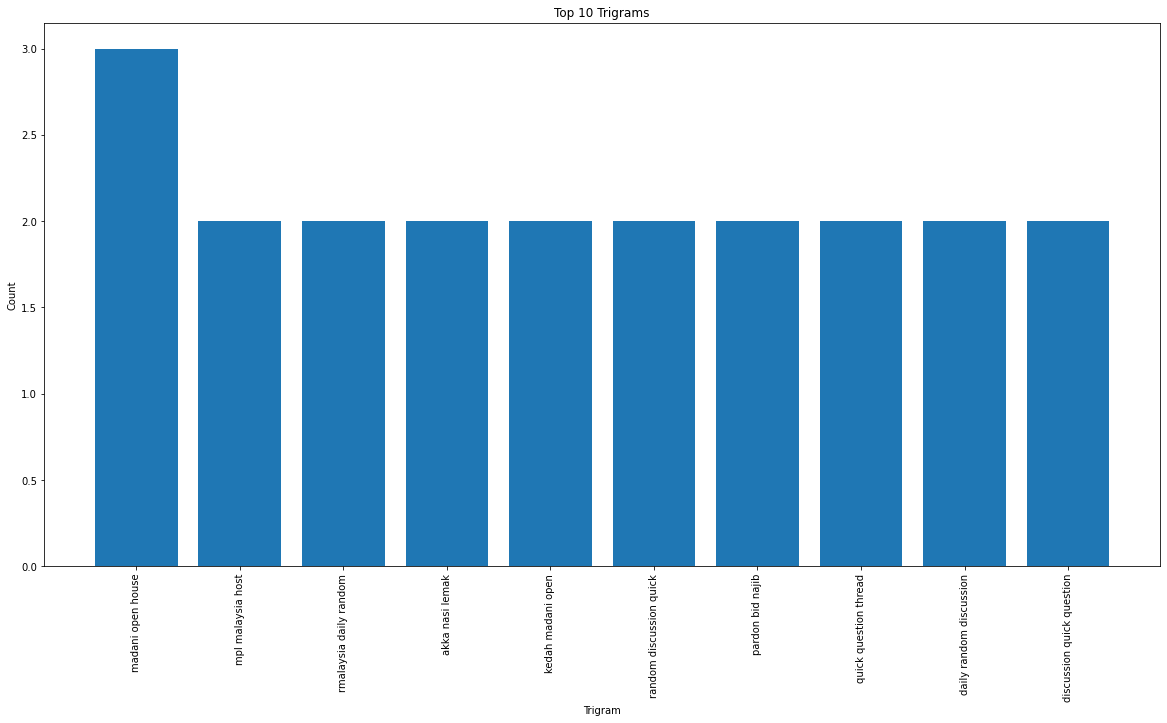

In [20]:
# Group the trigrams DataFrame by the "word1", "word2", and "word3" columns, and count the occurrences of each trigram
trigram_counts = trigrams_df.groupBy(["word1", "word2", "word3"]).count()

# Sort the trigram counts in descending order
trigram_counts = trigram_counts.orderBy("count", ascending=False)

# Take the top 10 trigram counts
top_trigram_counts = trigram_counts.limit(10)

# Convert the top trigram counts to a Pandas DataFrame
top_trigram_counts_df = top_trigram_counts.toPandas()

# Combine the "word1", "word2", and "word3" columns into a single "trigram" column for plotting
top_trigram_counts_df["trigram"] = top_trigram_counts_df["word1"] + " " + top_trigram_counts_df["word2"] + " " + top_trigram_counts_df["word3"]

# Plot the top 10 trigram counts as a bar chart
plt.figure(figsize=(20,10))
plt.bar(x=top_trigram_counts_df["trigram"], height=top_trigram_counts_df["count"])
plt.xticks(rotation=90)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 10 Trigrams")
plt.show()

#### WordCloud for top 20 trigrams

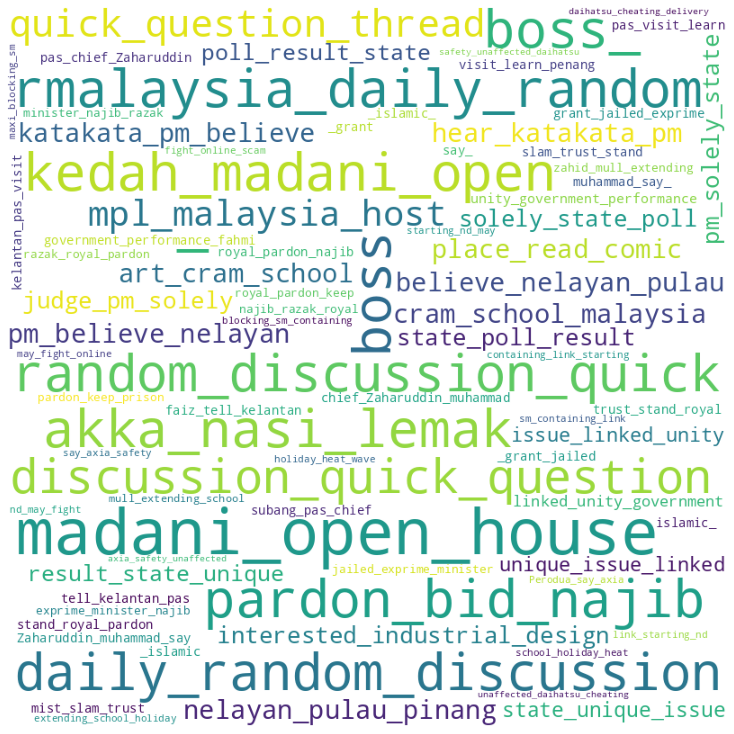

In [21]:
# Convert the DataFrame to a list of bigrams
trigrams = trigrams_df.rdd.map(lambda row: '_'.join(row)).collect()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(trigrams))

# Visualize the WordCloud
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### KeyBert model

In [22]:
# Flatten the DataFrame to get a single column of words
words_df = spark_df.select(explode(col("tokens")).alias('word'))

# Create an RDD from the flattened DataFrame
words_rdd = words_df.rdd

# combine all rows of rdd to one row
words_list = words_rdd.map(lambda x: x[0]).collect()
print(f"Word Count: {len(words_list)}")

# Initialize the KeyBERT model
model = KeyBERT()

keybert_keywords = model.extract_keywords(" ".join(words_list))

print(keybert_keywords)

Word Count: 1196
[('malaysia', 0.4866), ('malaysias', 0.4801), ('selangor', 0.4726), ('penang', 0.4681), ('malaysianow', 0.4508)]


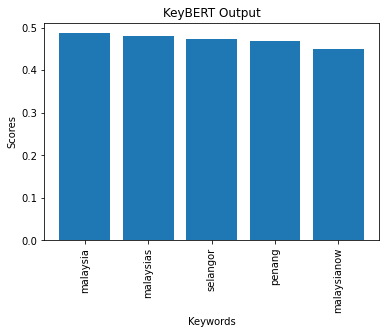

In [23]:
# Split the list of tuples into separate lists for words and scores
words, scores = zip(*keybert_keywords)

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(words, scores)

# Set the x-axis labels to be vertical for readability
plt.xticks(rotation='vertical')

# Set the chart title and axis labels
ax.set_title('KeyBERT Output')
ax.set_xlabel('Keywords')
ax.set_ylabel('Scores')

# Show the chart
plt.show()

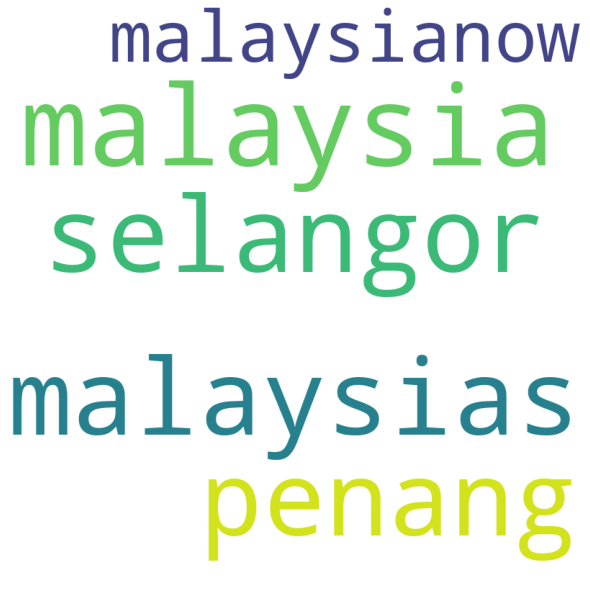

In [24]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', contour_width=3, contour_color='steelblue').generate_from_frequencies(dict(keybert_keywords))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

### Yet Another Keyword Extractor (Yake)

In [25]:
# Flatten the DataFrame to get a single column of words
words_df = spark_df.select(explode(col("tokens")).alias('word'))

# Create an RDD from the flattened DataFrame
words_rdd = words_df.rdd

# combine all rows of rdd to one row
words_list = words_rdd.map(lambda x: x[0]).collect()
print(f"Word Count: {len(words_list)}")

# Initialize the Yake algorithm
model = yake.KeywordExtractor()

yake_keywords = model.extract_keywords(" ".join(words_list))

print(yake_keywords)

Word Count: 1196
[('madani open house', 5.497207377647217e-05), ('kedah madani open', 0.00011102773339613747), ('daily random discussion', 0.00012196337708258705), ('random discussion quick', 0.00012196337708258705), ('discussion quick question', 0.00012744819126308098), ('open house open', 0.00013205407653501457), ('rmalaysia daily random', 0.00013433609296841873), ('quick question thread', 0.00014037951975354233), ('akka nasi lemak', 0.00014796920273484588), ('pardon bid najib', 0.00014849140005085786), ('open goal JPJ', 0.00016212350023830149), ('house question Act', 0.00016532215333203975), ('open house rmalaysia', 0.00018773305126993596), ('raya open house', 0.0002032972841986676), ('pmx open house', 0.00020566593917860528), ('open house itap', 0.000214473130707976), ('open house fly', 0.000214473130707976), ('house open goal', 0.000214473130707976), ('open house focusing', 0.000214473130707976), ('question Act child', 0.0002210759650592566)]


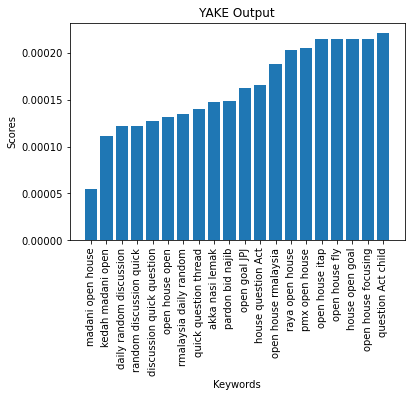

In [26]:
# Split the list of tuples into separate lists for words and scores
words, scores = zip(*yake_keywords)

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(words, scores)

# Set the x-axis labels to be vertical for readability
plt.xticks(rotation='vertical')

# Set the chart title and axis labels
ax.set_title('YAKE Output')
ax.set_xlabel('Keywords')
ax.set_ylabel('Scores')

# Show the chart
plt.show()

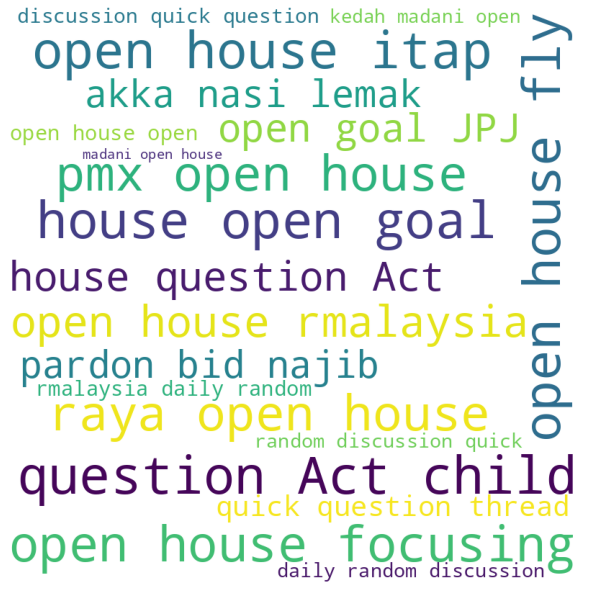

In [27]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', contour_width=3, contour_color='steelblue').generate_from_frequencies(dict(yake_keywords))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

#### Text Rank

In [29]:
# Load the spaCy model and add PyTextRank to the pipeline
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("textrank")

# Flatten the DataFrame to get a single column of words
words_df = spark_df.select(explode(col("tokens")).alias('word'))

# Create an RDD from the flattened DataFrame
words_rdd = words_df.rdd

# combine all rows of rdd to one row
words_list = words_rdd.map(lambda x: x[0]).collect()

doc = nlp(" ".join(words_list))

textrank_keywords = {}
# Print the top 10 keywords and their TextRank scores
for phrase in doc._.phrases[:10]:
    textrank_keywords[phrase.text] = phrase.rank
    print(f"{phrase.text:<30} {phrase.rank:<10}")   


unity government               0.05056209703861381
pm kedah madani open house     0.050283829887984986
dpm zahid kedah madani open house 0.049989228542571464
umno pardon                    0.04884226193292313
unity government policy meal australian government declassified report plane crash 0.04873296123237312
chief minister unity government 0.04862195529147609
anderson malaysia              0.04838809321153538
kedah madani                   0.047855683389521175
malaysia                       0.04780962575165576
foe malaysia                   0.04739742060323891


In [30]:
print(textrank_keywords)

{'unity government': 0.05056209703861381, 'pm kedah madani open house': 0.050283829887984986, 'dpm zahid kedah madani open house': 0.049989228542571464, 'umno pardon': 0.04884226193292313, 'unity government policy meal australian government declassified report plane crash': 0.04873296123237312, 'chief minister unity government': 0.04862195529147609, 'anderson malaysia': 0.04838809321153538, 'kedah madani': 0.047855683389521175, 'malaysia': 0.04780962575165576, 'foe malaysia': 0.04739742060323891}


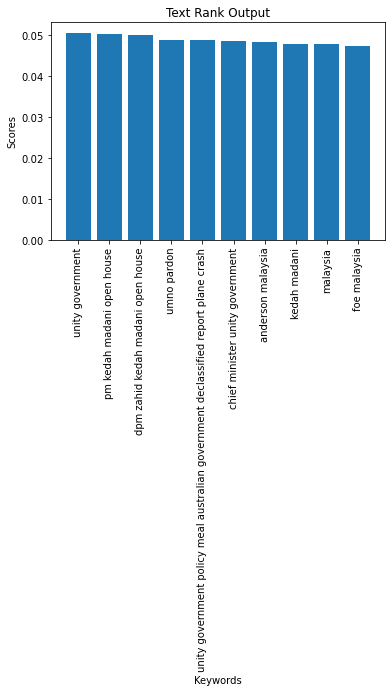

In [31]:
# Split the dictiorary into separate lists for words and scores
words, scores = zip(*textrank_keywords.items())

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(words, scores)

# Set the x-axis labels to be vertical for readability
plt.xticks(rotation='vertical')

# Set the chart title and axis labels
ax.set_title('Text Rank Output')
ax.set_xlabel('Keywords')
ax.set_ylabel('Scores')

# Show the chart
plt.show()

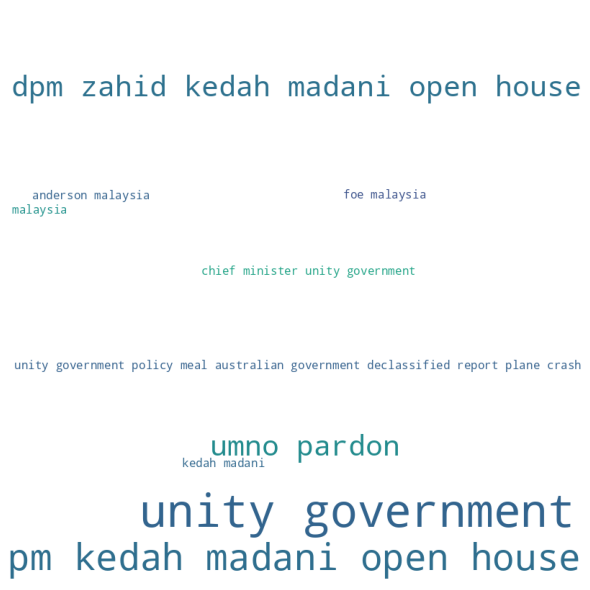

In [32]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', contour_width=3, contour_color='steelblue').generate_from_frequencies(dict(textrank_keywords))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

#### Rake_NLTK

In [51]:
# Flatten the DataFrame to get a single column of words
words_df = spark_df.select(explode(col("tokens")).alias('word'))

# Create an RDD from the flattened DataFrame
words_rdd = words_df.rdd

# create a list of words where the words are joined by a space
words_list = words_rdd.map(lambda x: x[0]).collect()

r = Rake()
r.extract_keywords_from_text(" ".join(words_list))
r.get_ranked_phrases()[:10]

['boss ” – najib youngest son get engaged rmalaysia daily random discussion quick question thread may pmx instructing stop new madani billboard tnb single phase phase conversion loan accessible smes sarawak ha commercial bank say premier want setup bank malay version jisoos flower chinese school get double fund islamic school asks umno youth malaysianow exgoldman banker ng seek delay start year sentence wild dragon fruit sg long key takeaway bank nation annual report state economy prospective job market malaysia central bank predicts financial year men seen fighting woodland checkpoint hit helmet maybe bad nur afrinas run chase wa exhilarating congratulation malaysia kuala lumpur skyline night took recently bukit ampang non muslim malaysian married muslim foreigner go marriage registration jpn putrajaya style wes anderson celcom digi user continue enjoy free g access may anwars raya open house open goal jpj issue notice motorcycle seized nationwide aidilfitri ops feeling airline sticke

In [45]:
r.get_ranked_phrases_with_scores()

[(58208.02019230771,
  'boss ” – najib youngest son get engaged rmalaysia daily random discussion quick question thread may pmx instructing stop new madani billboard tnb single phase phase conversion loan accessible smes sarawak ha commercial bank say premier want setup bank malay version jisoos flower chinese school get double fund islamic school asks umno youth malaysianow exgoldman banker ng seek delay start year sentence wild dragon fruit sg long key takeaway bank nation annual report state economy prospective job market malaysia central bank predicts financial year men seen fighting woodland checkpoint hit helmet maybe bad nur afrinas run chase wa exhilarating congratulation malaysia kuala lumpur skyline night took recently bukit ampang non muslim malaysian married muslim foreigner go marriage registration jpn putrajaya style wes anderson celcom digi user continue enjoy free g access may anwars raya open house open goal jpj issue notice motorcycle seized nationwide aidilfitri ops 

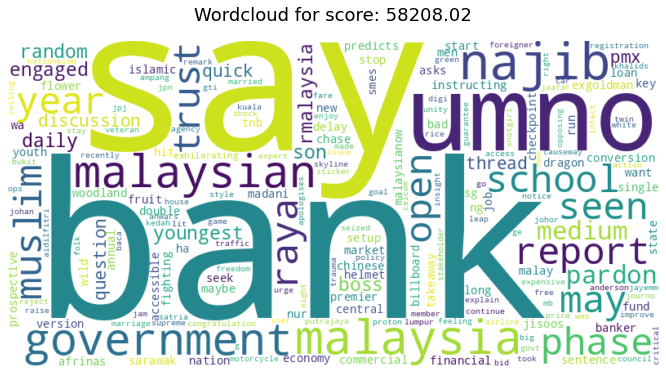

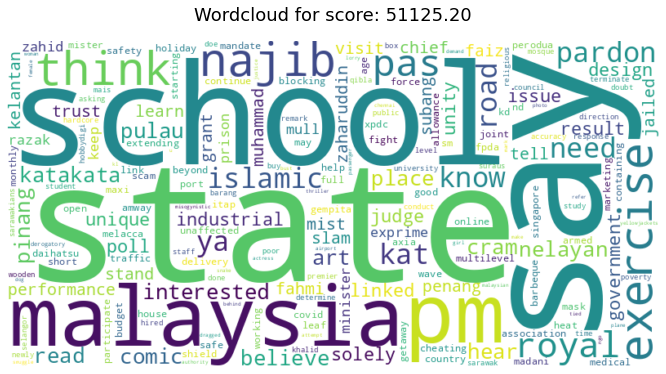

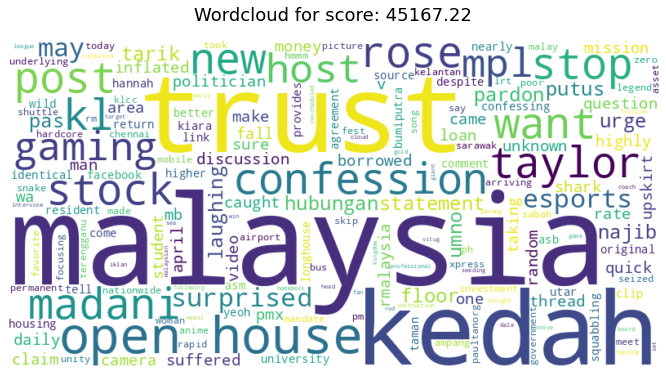

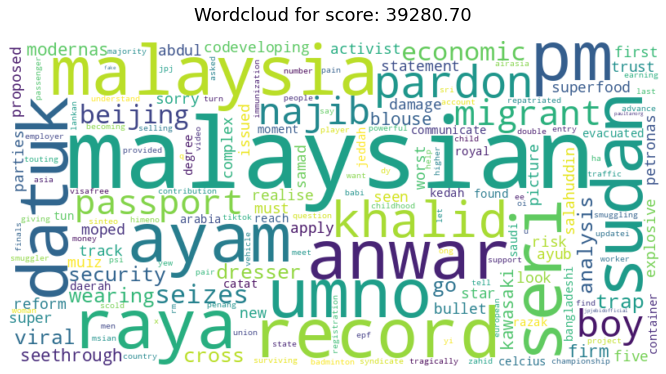

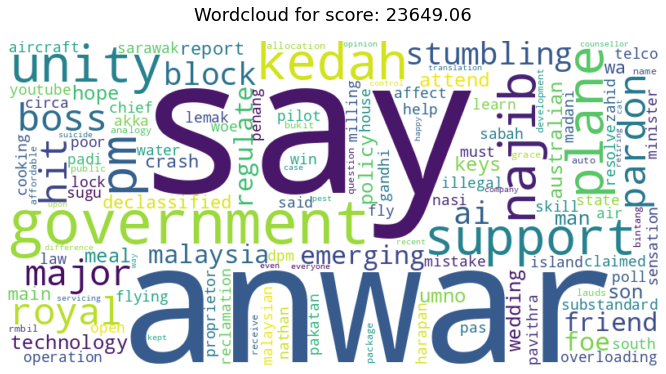

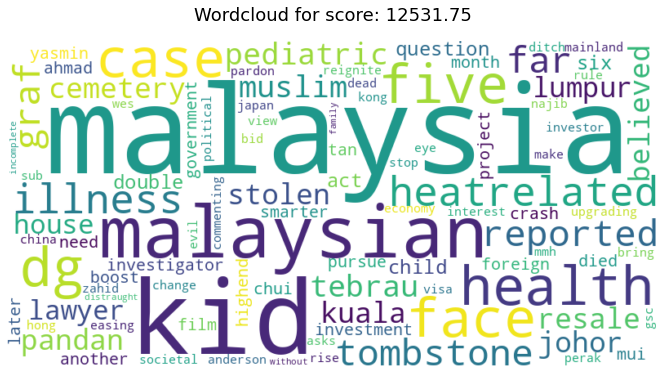

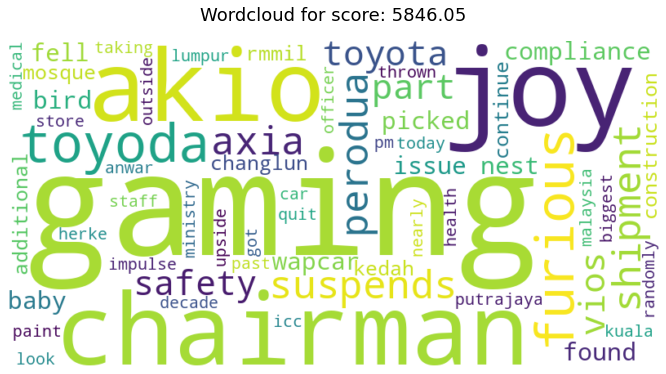

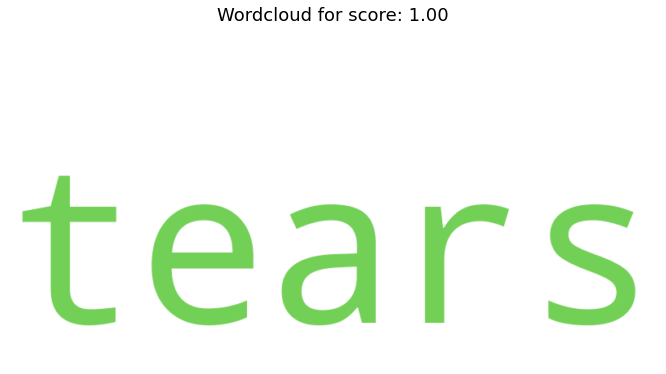

In [71]:
lst = r.get_ranked_phrases_with_scores()
# Loop through the list of tuples and create a wordcloud for each score
for score, text in lst:
    # Create the WordCloud object with the text and some parameters
    wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=200, relative_scaling=0.5).generate(text)
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add the title and score to the figure
    ax.set_title("Wordcloud for score: {:.2f}".format(score), fontsize=18, pad=20)
    
    # Display the wordcloud on the axis
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    
    # Show the figure
    plt.show()